In [72]:
import torch 
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch import nn
import torch.optim as optim

In [73]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [74]:
# Creating CNA -> conv+ batch_norm + relu
class CNA(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNA, self).__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

# Creating a modified inception block  
class Inception_block(nn.Module):
    def __init__(self, in_channels, filterB1_1, filterB2_1, filterB2_2, filterB3_1, filterB3_2, filterB4):
        super(Inception_block, self).__init__()

        self.branch1 = CNA(in_channels, filterB1_1, kernel_size=1)

        self.branch2 = nn.Sequential(
            CNA(in_channels, filterB2_1, kernel_size=3, padding=1),
            CNA(filterB2_1, filterB2_2, kernel_size=5, padding=2)
        )

        self.branch3 = nn.Sequential(
            CNA(in_channels, filterB3_1, kernel_size=3, padding=1),
            CNA(filterB3_1, filterB3_2, kernel_size=5, padding=2)
        )

        self.branch4 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.branch4_conv = CNA(in_channels, filterB4, kernel_size=1)

    def forward(self, x):
        branch1_out = self.branch1(x)
        branch2_out = self.branch2(x)
        branch3_out = self.branch3(x)
        branch4_out = self.branch4_conv(self.branch4(x))
        return torch.cat([branch1_out, branch2_out, branch3_out, branch4_out], 1)
    
# Using 4 inception blocks to make an inception network
class Inception_Module_vision(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(Inception_Module_vision, self).__init__()

        self.inception1 = Inception_block(in_channels, 4, 4, 4, 2, 2, 2)  # output channels = 4 + 4 + 2 + 2 = 12
        self.inception2 = Inception_block(12, 8, 8, 8, 4, 4, 4)          # output channels = 8 + 8 + 4 + 4 = 24
        self.inception3 = Inception_block(24, 16, 8, 16, 8, 8, 8)        # output channels = 16 + 16 + 8 + 8 = 48
        self.inception4 = Inception_block(48, 16, 12, 16, 8, 8, 8)       # output channels = 16 + 16 + 8 + 8 = 48

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(48, num_classes)

    def forward(self, x):
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x



In [75]:
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


In [76]:
def train2d(model, train_loader, loss_func, optimizer):
    batch_loss = 0.0
    correct = 0
    total = 0
    model.train()  # Set the model to training mode
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_loss += loss.item()
        _, predicted_indices = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted_indices == labels).sum().item()

    epoch_loss = batch_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate2d(model, loader, loss_func):
    model.eval()  # Set the model to evaluation mode
    batch_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            batch_loss += loss.item() * inputs.size(0)
            _, predicted_indices = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted_indices == labels).sum().item()

    epoch_loss = batch_loss / len(loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [77]:
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

num_epochs = 20
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

model_2d = Inception_Module_vision().to(device=device)
loss_func2d = nn.CrossEntropyLoss()
optimizer2d = optim.Adam(model_2d.parameters(), lr=0.0003)

# Training and validation loops
for epoch in range(num_epochs):
    train_loader = DataLoader(training_data, batch_size=128, shuffle=True)
    train_loss, train_acc = train2d(model_2d, train_loader, loss_func2d, optimizer2d)
    val_loss, val_acc = validate2d(model_2d, test_loader, loss_func2d)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


Epoch 1/20, Train Loss: 0.0144, Train Acc: 0.3376, Val Loss: 1.6273, Val Acc: 0.4046
Epoch 2/20, Train Loss: 0.0118, Train Acc: 0.4611, Val Loss: 1.4367, Val Acc: 0.4765
Epoch 3/20, Train Loss: 0.0107, Train Acc: 0.5121, Val Loss: 1.3523, Val Acc: 0.5127
Epoch 4/20, Train Loss: 0.0100, Train Acc: 0.5488, Val Loss: 1.2365, Val Acc: 0.5538
Epoch 5/20, Train Loss: 0.0094, Train Acc: 0.5712, Val Loss: 1.1964, Val Acc: 0.5706
Epoch 6/20, Train Loss: 0.0090, Train Acc: 0.5923, Val Loss: 1.1663, Val Acc: 0.5801
Epoch 7/20, Train Loss: 0.0087, Train Acc: 0.6071, Val Loss: 1.1761, Val Acc: 0.5748
Epoch 8/20, Train Loss: 0.0084, Train Acc: 0.6190, Val Loss: 1.0821, Val Acc: 0.6081
Epoch 9/20, Train Loss: 0.0081, Train Acc: 0.6318, Val Loss: 1.0768, Val Acc: 0.6129
Epoch 10/20, Train Loss: 0.0080, Train Acc: 0.6398, Val Loss: 1.0275, Val Acc: 0.6353
Epoch 11/20, Train Loss: 0.0077, Train Acc: 0.6497, Val Loss: 1.0087, Val Acc: 0.6410
Epoch 12/20, Train Loss: 0.0076, Train Acc: 0.6576, Val Loss: 1

In [78]:
#Saving model parameters
torch.save(model_2d.state_dict(), 'Inception_vision.pt')

In [79]:
#Loading the trained model parameters
model = Inception_Module_vision()
model.load_state_dict(torch.load('Inception_vision.pt'))

<All keys matched successfully>

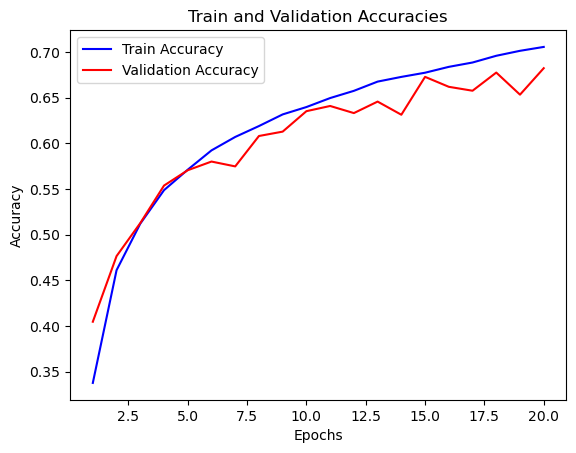

In [80]:
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_accuracies, 'b', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
plt.title('Train and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()